# Shape analysis of curves with the Square Root Velocity metric

Lead author: Alice Le Brigant.

In this notebook, we demonstrate how to compute distances between shapes of curves in $\mathbb R^2$ and $\mathbb R^3$ using the [`discrete_curves.py`](https://github.com/geomstats/geomstats/blob/master/geomstats/geometry/discrete_curves.py) module. This is achieved by using a reparametrization-invariant metric - here, we use the Square Root Velocity metric (see [SKJJ2011](#References)) - and by quotienting out several shape-preserving actions. Translation and scaling can be removed by respectively translating the curve to start at the origin and rescaling it to have length one, while rotation and reparametrization are quotiented out by alignment procedures. In particular, we will focus on quotienting out the action of reparametrization using an optimal matching algorithm (see [LAB2017](#References)).  

In [2]:
import matplotlib.pyplot as plt

import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)

INFO: Using numpy backend


In [3]:
def plot_curve(curve, fmt="o-k", ax=None, add_origin=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    if add_origin:
        curve = insert_zeros(curve, axis=-2)
    ax.plot(curve[:, 0], curve[:, 1], fmt)

    return ax


def plot_geodesic(geod, translation=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    geod = insert_zeros(geod, axis=-2)

    if translation is not None:
        geod = geod + gs.expand_dims(translation, axis=-2)

    ax.plot(geod[0, :, 0], geod[0, :, 1], "o-b")
    ax.plot(geod[-1, :, 0], geod[-1, :, 1], "o-r")

    for i in range(1, n_times - 1):
        ax.plot(geod[i, :, 0], geod[i, :, 1], "k")

    for j in range(k_sampling_points):
        ax.plot(geod[:, j, 0], geod[:, j, 1], "--k")

    return ax

## 1. A first example in 2D

We start by showing the basic steps to compare shapes of 2D curves. More details on the operations shown below will be given in Section 2.

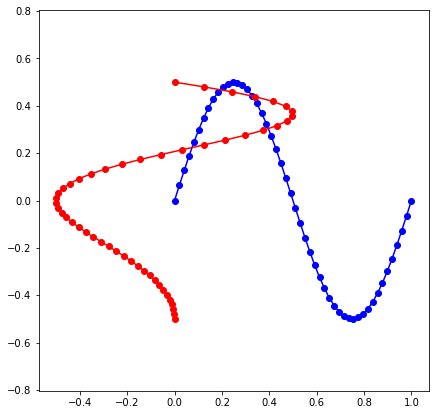

In [4]:
k_sampling_points = 50

xx = gs.linspace(0.0, 1.0, k_sampling_points)
curve_a = gs.vstack((xx, gs.sin(2 * gs.pi * xx) / 2)).T
curve_b = gs.vstack((-gs.sin(2 * gs.pi * xx**2) / 2, xx)).T - gs.array([0.0, 0.5])

ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
plt.axis("equal")
plt.show()

We first remove translation by translating both curves to the origin, which can be seen as a projection from the space of discrete curves to the space of discrete curves starting at the origin `curves_r2`. Notice that we remove $(0., 0.)$ from the representation as we know all the curves start at the origin, so that projected curves have shape `(k_sampling_points - 1, 2)`. Then we remove scaling by normalizing the curves, i.e. rescaling them to have unit length.

In [5]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)

curve_a = curves_r2.projection(curve_a)
curve_b = curves_r2.projection(curve_b)

curve_a = curves_r2.normalize(curve_a)
curve_b = curves_r2.normalize(curve_b)

We then equip the space of curves `curves_r2` with a reparametrization invariant metric - here, the Square Root Velocity metric (see [SKJJ2011](#References)) - and we quotient out rotations and reparametrizations. The alignment procedure is then accessible through `curves_r2.fiber_bundle.align`. During alignment, the first curve stays fixed while the second curve is alternatively rotated and reparametrized to best "fit" the first curve. 

The quotient metric induced on the shape space (space of curves modulo rotations and reparametrizations) can be called using `curves_r2.quotient.metric`. For example, we can compute the geodesic between the shapes of the two curves for this quotient metric. It corresponds to a horizontal geodesic in the space of curves, see Section 2.

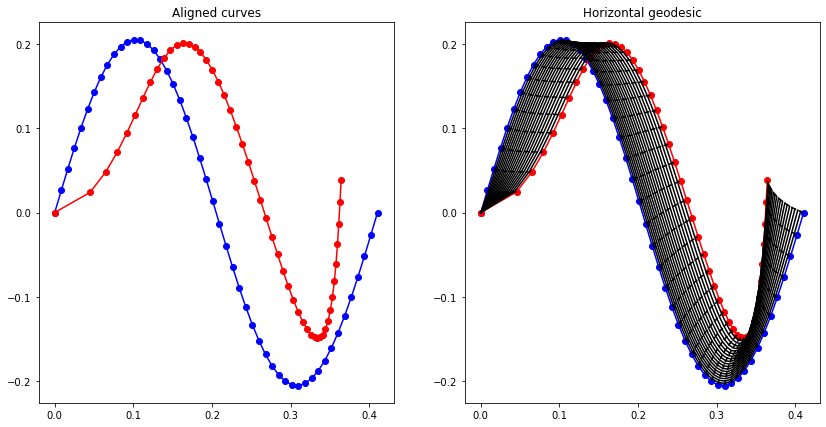

In [6]:
curves_r2.equip_with_metric(SRVMetric)
curves_r2.equip_with_group_action("rotations and reparametrizations")
curves_r2.equip_with_quotient_structure()

curve_b_aligned = curves_r2.fiber_bundle.align(curve_b, curve_a)

hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a, curve_b)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
hgeod = hgeod_fun(times)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_curve(curve_a, "o-b", ax=ax1)
plot_curve(curve_b_aligned, "o-r", ax=ax1)
ax1.set_title("Aligned curves")

plot_geodesic(hgeod, ax=ax2)
ax2.set_title("Horizontal geodesic")
plt.show()

### Remarks:

- In the discrete case, reparametrization corresponds to resampling, and we can see that the second (red) curve has been resampled so that parts of both curves that have similar "slope" are matched together.

- Computing the standard geodesic (i.e., for the metric between discrete curves) between the aligned curves yields the same result as computing the quotient metric geodesic between the initial curves.

In [7]:
geod = curves_r2.metric.geodesic(curve_a, curve_b_aligned)(times)

assert gs.all(gs.abs(geod - hgeod) < 1e-3)

- It is possible to obtain the optimal rotation that aligns the second curve to the first. This can be useful to make sure that the points of the aligned curve indeed belong to the rotated initial curve.

In [8]:
_, rotation = curves_r2.fiber_bundle.align(curve_b, curve_a, return_rotation=True)
curve_b_rotated = curve_b @ rotation.T

- Notice that it is also possible to align only with respect to rotations, and only with respect to reparametrizations. If we do the first alignment followed by the second, we get a different result than when we perform both alignments simultaneously as above. This is because, when performed simultaneously, both alignements are alternatively made until convergence is reached.

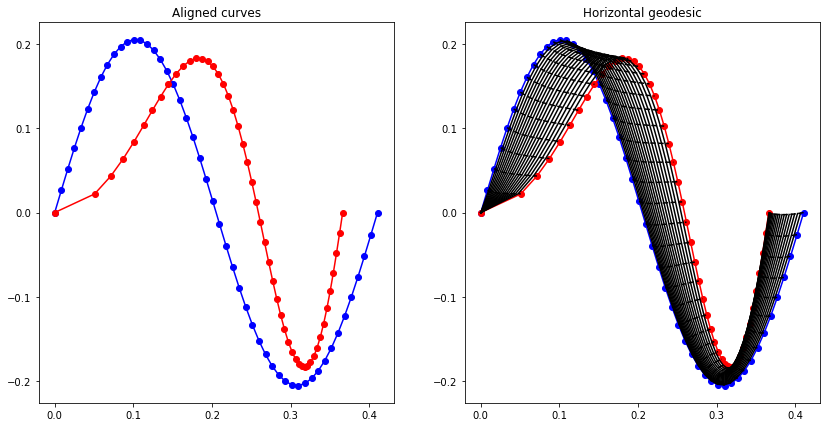

In [10]:
curves_r2.equip_with_group_action("rotations")
curves_r2.equip_with_quotient_structure()

curve_b_rotated = curves_r2.fiber_bundle.align(curve_b, curve_a)

curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

curve_b_aligned = curves_r2.fiber_bundle.align(curve_b_rotated, curve_a)

hgeod_fun = curves_r2.metric.geodesic(curve_a, curve_b_aligned)
hgeod = hgeod_fun(times)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_curve(curve_a, "o-b", ax=ax1)
plot_curve(curve_b_aligned, "o-r", ax=ax1)
ax1.set_title("Aligned curves")

plot_geodesic(hgeod, ax=ax2)
ax2.set_title("Horizontal geodesic")
plt.show()

## 2. Focus on quotienting out reparametrizations

We now examine another basic example of 2D curves and focus on quotienting out the action of reparametrizations. We consider the following parametrized curves.

In [11]:
parametrized_curve_a = lambda x: gs.transpose(
    gs.array([1 + 2 * gs.sin(gs.pi * x), 3 + 2 * gs.cos(gs.pi * x)])
)
parametrized_curve_b = lambda x: gs.transpose(
    gs.array([5 * gs.ones(len(x)), 4 * (1 - x) + 1])
)

In practice, we work with discrete curves, i.e. sample points from the parametrized curves. 

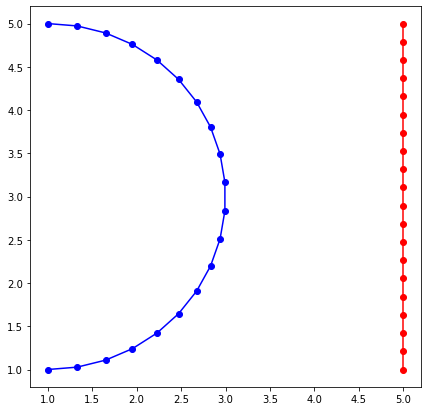

In [12]:
k_sampling_points = 20
sampling_points = gs.linspace(0.0, 1.0, k_sampling_points)

curve_a = parametrized_curve_a(sampling_points)
curve_b = parametrized_curve_b(sampling_points)

ax = plot_curve(curve_a, "o-b", add_origin=False)
plot_curve(curve_b, "o-r", ax=ax, add_origin=False)
plt.show()

We also remove translation.

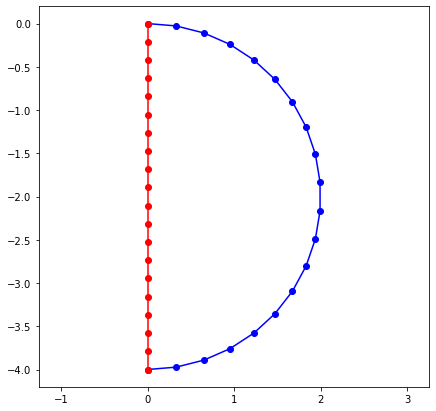

In [13]:
curves_r2 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=2, k_sampling_points=k_sampling_points, equip=False
)

curve_a0 = curves_r2.projection(curve_a)
curve_b0 = curves_r2.projection(curve_b)

ax = plot_curve(curve_a0, "o-b")
plot_curve(curve_b0, "o-r", ax=ax)
plt.axis("equal")
plt.show()

### 2.1. Comparing parametrized curves

Here we use again the so-called Square Root Velocity metric to compare parametrized curves. This metric computes an $L^2$ distance between the velocities of the curves, suitably renormalized to get reparametrization invariance. See [SKJJ2011](#References) for more details.

In [14]:
curves_r2.equip_with_metric(SRVMetric)

curves_r2.metric.dist(point_a=curve_a0, point_b=curve_b0)

1.972134949925512

The distance, as any Riemannian distance, is computed as the length of the geodesic. Although this is a geodesic between curves starting at the origin, we can visualize it as a geodesic between the initial curves `curve_a` and `curve_b` by adding a translation. 

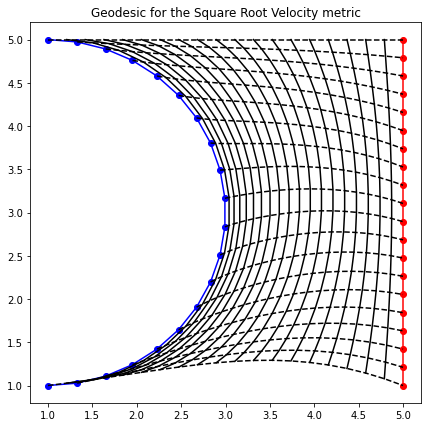

In [15]:
geod_fun = curves_r2.metric.geodesic(curve_a0, curve_b0)

n_times = 20
times = gs.linspace(0.0, 1.0, n_times)
geod = geod_fun(times)
translation = gs.linspace(curve_a[0], curve_b[0], n_times)

plot_geodesic(geod, translation)
plt.title("Geodesic for the Square Root Velocity metric")
plt.show()

The Square Root Velocity metric is reparametrization invariant in the sense that, if the two curves are reparametrized *in the same way*, the distance does not change. The (small) difference we see in the distances is due to discretization, and will go to zero as the number of sampling points increases.

In [16]:
curve_a_resampled = parametrized_curve_a(sampling_points**2)
curve_b_resampled = parametrized_curve_b(sampling_points**2)

curve_a0_resampled = curves_r2.projection(curve_a_resampled)
curve_b0_resampled = curves_r2.projection(curve_b_resampled)

curves_r2.metric.dist(curve_a0_resampled, curve_b0_resampled)

1.9694017211949013

The geodesic keeps the same "shape".

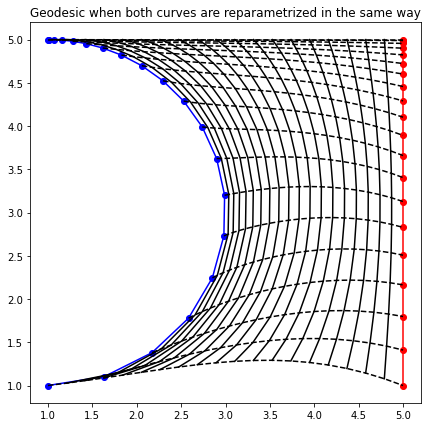

In [17]:
geod_fun_1 = curves_r2.metric.geodesic(curve_a0_resampled, curve_b0_resampled)
geod_1 = geod_fun_1(times)

plot_geodesic(geod_1, translation=translation)
plt.title("Geodesic when both curves are reparametrized in the same way")
plt.show()

However, if the curves are reparametrized in *different* ways, the distance changes, and so does the shape of the geodesic.

In [18]:
curves_r2.metric.dist(curve_a0, curve_b0_resampled)

2.0180332363264095

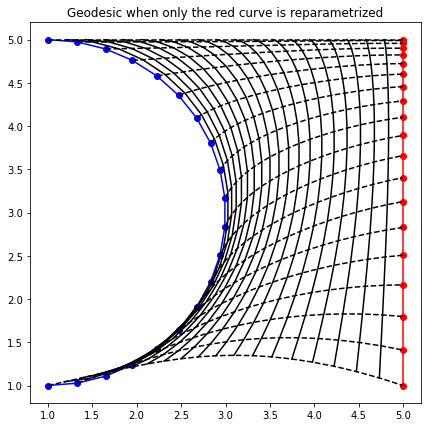

In [19]:
geod_fun_2 = curves_r2.metric.geodesic(curve_a0, curve_b0_resampled)
geod_2 = geod_fun_2(times)

plot_geodesic(geod_2, translation=translation)
plt.title("Geodesic when only the red curve is reparametrized")
plt.show()

### 2.2. Comparing unparametrized curves

In order to completely quotient out parametrization, distances are computed in the base space of a fiber bundle where the fibers represent equivalent classes of curves with the same shape (i.e. equal modulo reparametrization). Any infinitesimal deformation of a curve can be split into the sum of vertical deformation (tangent to the fiber) that simply reparametrizes the curve without changing its shape, and a horizontal deformation (orthogonal to the fiber) that changes the shape. The distance between two unparametrized curves is then computed as the length of a horizontal geodesic linking their two fibers. 

In practice, to compute the horizontal geodesic linking the fibers of two discrete parametrized curves `curve_a0` and `curve_b0`, we can fix the parametrization of `curve_a0`, and search for a reparametrization of `curve_b0` (i.e. another discrete curve with same shape as `curve_b0`) that best "matches" `curve_a0`. 

In order to completely quotient out parametrization, distances are computed in the base space of a fiber bundle where the fibers represent equivalent classes of curves with the same shape (i.e. equal modulo reparametrization). Any infinitesimal deformation of a curve can be split into the sum of vertical deformation (tangent to the fiber) that simply reparametrizes the curve without changing its shape, and a horizontal deformation (orthogonal to the fiber) that changes the shape. The distance between two unparametrized curves is then computed as the length of a horizontal geodesic linking their two fibers. 

In practice, to compute the horizontal geodesic linking the fibers of two discrete parametrized curves `curve_a0` and `curve_b0`, we can fix the parametrization of `curve_a0`, and search for a reparametrization of `curve_b0` (i.e. another discrete curve with same shape as `curve_b0`) that best "matches" `curve_a0`. 

In [20]:
curves_r2.equip_with_group_action("reparametrizations")
curves_r2.equip_with_quotient_structure()

geod_velocity = (n_times - 1) * (geod[1:] - geod[:-1])

bundle = curves_r2.fiber_bundle
geod_velocity_hor = bundle.horizontal_projection(geod_velocity, geod[:-1])
geod_velocity_ver = bundle.vertical_projection(geod_velocity, geod[:-1])

shooted_geod_fun = curves_r2.metric.geodesic(
    initial_point=curve_a0, initial_tangent_vec=geod_velocity_hor[0]
)
shooted_geod = shooted_geod_fun(times)

The problem with this idea is that, while it yields a horizontal geodesic starting at `curve_a0`, its end point does not belong to the fiber of `curve_b0`: as we can see below, the end curve of the horizontal geodesic is not a reparametrization of the initial red curve, it does not have the same shape.

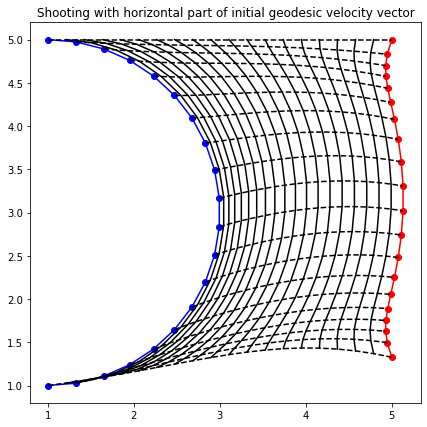

In [21]:
plot_geodesic(shooted_geod, translation=translation)
plt.title("Shooting with horizontal part of initial geodesic velocity vector")
plt.show()

To obtain a horizontal geodesic starting at `curve_a0` and ending at a curve with same shape as `curve_b0`, we use an iterative optimal matching algorithm [LAB2017](#References). This algorithm moves along the fiber of `curve_b0` to find the best representative with respect to `curve_a0` by iterating the following steps:

- step 1: compute the geodesic between `curve_a0` and the current representative of `curve_b0` (initially, `curve_b`)
- step 2: compute the path whose velocity is a reparametrization of the horizontal part of the geodesic velocity at all time, and set the new representative of `curve_b0` to be the end point of this path.

Note that the first step yields a geodesic that is not horizontal, while the second step yields a horizontal path that is not geodesic. By iterating these two steps, the algorithm converges to a horizontal geodesic.

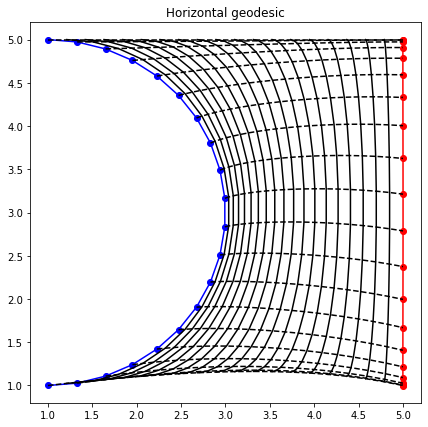

In [22]:
hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a0, curve_b0)
hgeod = hgeod_fun(times)

plot_geodesic(hgeod, translation=translation)
plt.title("Horizontal geodesic")
plt.show()

We can check the horizontality of this geodesic by computing the norm of the vertical part of its velocity for all times.

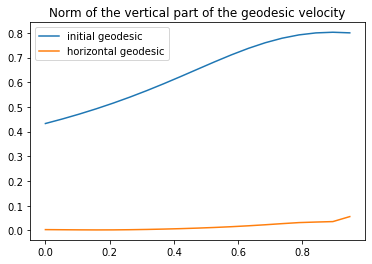

In [23]:
geod_vertical_norm = curves_r2.metric.norm(geod_velocity_ver, geod[:-1])

hgeod_velocity = (n_times - 1) * (hgeod[1:] - hgeod[:-1])
hgeod_velocity_ver = curves_r2.fiber_bundle.vertical_projection(
    hgeod_velocity, hgeod[:-1]
)
hgeod_vertical_norm = curves_r2.metric.norm(hgeod_velocity_ver, hgeod[:-1])

plt.figure()
plt.plot(times[:-1], geod_vertical_norm, label="initial geodesic")
plt.plot(times[:-1], hgeod_vertical_norm, label="horizontal geodesic")
plt.legend()
plt.title("Norm of the vertical part of the geodesic velocity")
plt.show()

We can also check that this horizontal geodesic does not change if we resample the end curve.

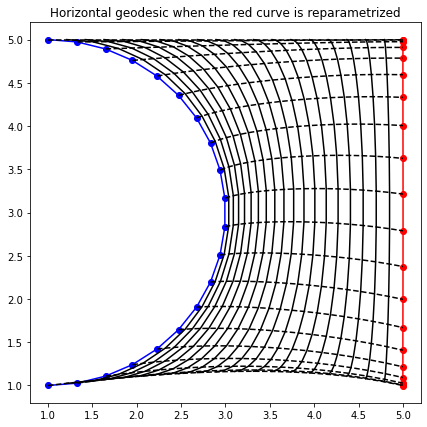

In [24]:
hgeod_fun = curves_r2.quotient.metric.geodesic(curve_a0, curve_b0_resampled)
hgeod = hgeod_fun(times)

plot_geodesic(hgeod, translation=translation)
plt.title("Horizontal geodesic when the red curve is reparametrized")
plt.show()

Finally, we can check that the quotient distance remains approximately constant for any parametrizations of the curves.

In [25]:
print(curves_r2.quotient.metric.dist(curve_a0, curve_b0))
print(curves_r2.quotient.metric.dist(curve_a0_resampled, curve_b0))
print(curves_r2.quotient.metric.dist(curve_a0_resampled, curve_b0))
print(curves_r2.quotient.metric.dist(curve_a0, curve_b0_resampled))

1.7862729308547018
1.7858568350137172
1.7858568350137172
1.7862625702843318


## 3. Example in 3D

Finally, we show an example for curves in $\mathbb R^3$. We will use the following functions to plot our results.

In [26]:
def plot_curve_3d(curve, fmt="k", ax=None, add_origin=True):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        curve = insert_zeros(curve, axis=-2)

    ax.plot(*[curve[:, k] for k in range(3)], fmt)
    ax.scatter(*[curve[0, k] for k in range(3)], fmt)
    return ax


def plot_geodesic_3d(geod_points, ax=None, add_origin=True):
    n_times = geod_points.shape[0]
    k_sampling_points = geod_points.shape[-2] + 1

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        geod_points = insert_zeros(geod_points, axis=-2)

    ax.plot(*[geod_points[0, :, k] for k in range(3)], "-", c="b", linewidth=2)
    ax.plot(*[geod_points[-1, :, k] for k in range(3)], "-", c="r", linewidth=2)

    for i in range(1, n_times - 1):
        ax.plot(*[geod_points[i, :, k] for k in range(3)], "-", c="k")

    for j in range(k_sampling_points - 1):
        ax.plot(*[geod_points[:, j, k] for k in range(3)], "--", c="k")

    return ax

In [27]:
k_sampling_points = 50

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3,
    k_sampling_points=k_sampling_points,
)

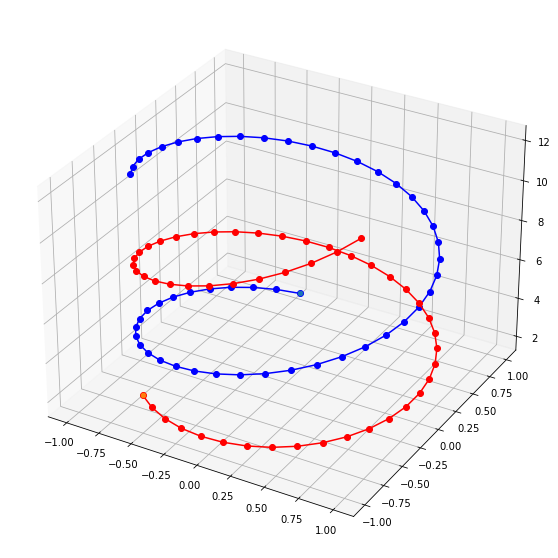

In [28]:
parametrized_curve_a = lambda x: gs.transpose(
    gs.stack((gs.cos(2 + 8 * x), gs.sin(2 + 8 * x), 2 + 10 * x))
)
parametrized_curve_b = lambda x: gs.transpose(
    gs.stack((gs.cos(4 + 8 * x), gs.sin(4 + 8 * x), 2 + 10 * x**2))
)

sampling_points = gs.linspace(0.0, 1.0, k_sampling_points)
curve_a = parametrized_curve_a(sampling_points)
curve_b = parametrized_curve_b(sampling_points)


ax = plot_curve_3d(curve_a, "o-b", add_origin=False)
plot_curve_3d(curve_b, "o-r", ax=ax, add_origin=False)
plt.show()

In [29]:
curve_a0 = curves_r3.projection(curve_a)
curve_b0 = curves_r3.projection(curve_b)

curve_a0 = curves_r3.normalize(curve_a0)
curve_b0 = curves_r3.normalize(curve_b0)

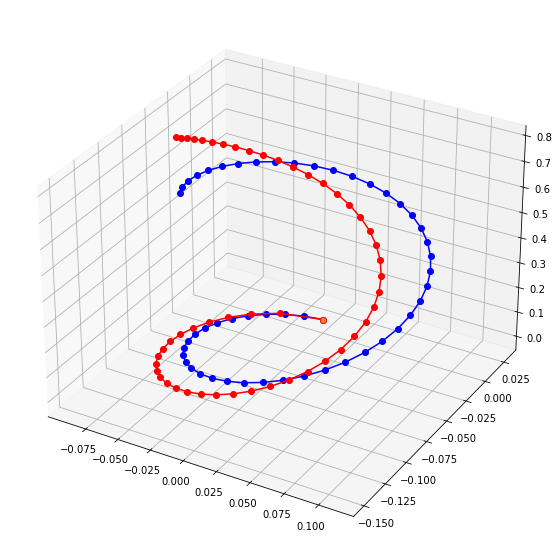

In [30]:
curves_r3.equip_with_group_action("rotations and reparametrizations")
curves_r3.equip_with_quotient_structure()

curve_b0_aligned = curves_r3.fiber_bundle.align(curve_b0, curve_a0)

ax = plot_curve_3d(curve_a0, "o-b")
plot_curve_3d(curve_b0_aligned, "o-r", ax=ax)
plt.show()

## References

.. [SKJJ2011] A. Srivastava, E. Klassen, S. H. Joshi and I. H. Jermyn,
    "Shape Analysis of Elastic Curves in Euclidean Spaces,"
    in IEEE Transactions on Pattern Analysis and Machine Intelligence,
    vol. 33, no. 7, pp. 1415-1428, July 2011.

.. [L2017] A. Le Brigant,
    "A discrete framework to find the optimal matching between manifold-valued curves,"
    in Journal of Mathematical Imaging and Vision, 61,
    pp. 40-70, 2019.